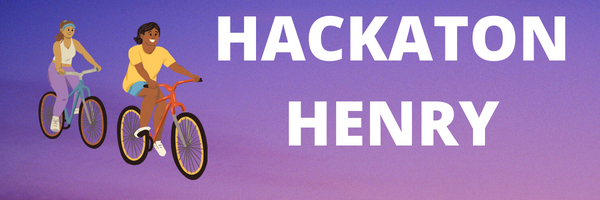

El siguiente trabajo que realice fue en base a 
trabajos de investigación donde muestran que el 
random forest. Permite trabajar de forma adecuada
el tipo de datos, primero contra la regresión lineal en forma de trabajos
de investigacición, hasta llegar a random forest.

En el paper:
Predicting Bike-Sharing Demand Using Random Forest
https://doi.org/10.1111/coin.12287
Los resultados muestran
que el modelo de RF tiene una alta precisión predictiva con un RMSE de 210
cnt/h, un MAE de 121 cnt/h y un R de 0,90. El rendimiento de la
El modelo de RF también se compara con un modelo de regresión lineal y muestra
precisión superior.

En cuanto al modelo de RNN podríamos decir lo siguiente:
    

Para resolver este problema, aportamos dos nuevos enfoques basados
en la memoria estándar a largo plazo (LSTM), 
que no solo puede aprovechar las entradas de funciones
múltiples y las salidas de pasos de múltiples tiempos para
mejorar la precisión de la predicción de bicicletas disponibles
en una sola vez. paso, pero también puede pronosticar el número 
de bicicletas en pasos de varios tiempos. Estos enfoques ayudarán
a las agencias de bicicletas compartidas a tomar una mejor decisión
para distribuir sus bicicletas a cada estibador de manera eficiente.
Los resultados experimentales confirmaron que nuestros modelos de 
pasos de múltiples funciones y de múltiples tiempos superan al modelo 
LSTM estándar.

https://www.kdnuggets.com/2019/06/random-forest-vs-neural-network.html

En comparación con LSTM y GBM ligero, Random Forest
mostró una mayor precisión y se desempeñó mejor con 
respecto a a los parámetros estadísticos utilizados para evaluar 
las predicciones (RMSE, MAE y R2). 


https://meetingorganizer.copernicus.org/EGU2019/EGU2019-3121-1.pdf#:~:text=Compared%20to%20LSTM%20and%20light%20GBM%2C%20Random%20Forests,among%20all%20the%20four%20air%20pollutants%20ex-%20amined.

In [516]:
import pandas as pd
import datetime as dt
import numpy as np
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import seaborn as sn
import matplotlib.pyplot as plt

from scipy import stats
import missingno as msno
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)


Las librerias para crear Random Forest son:
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    
para probar las metricas:
from sklearn.metrics import accuracy_score

para los dataframes:
    pandas

para los calculos matemáticos:
    numpy


El siguiente código presenta el dataframe de entrenamiento bike:
    

In [ ]:
train_df = pd.read_csv('bike_train.csv')
train_df['data_set'] = 'train'
train_df.head(5)

En el código de abajo, se esta convirtiendo la fecha agregandole
horas y minutos
también se busca si hay valores nan.

In [ ]:
train_df["dteday"]= pd.to_datetime(train_df["dteday"])
train_df["dteday"]=pd.to_datetime(train_df["dteday"]) + pd.to_timedelta(train_df['hr'], unit='h')
train_df.head(5)
train_df.isna().sum()


In [ ]:
train_df.dtypes

In [ ]:
print(train_df.head(5))

train_df = train_df.drop('data_set',axis=1)
train_df = train_df.drop('instant',axis=1)


In [514]:
categoryVariableList = ["hr","weekday","mnth","season","weathersit","holiday","workingday"]
for var in categoryVariableList:
    train_df[var] = train_df[var].astype("category")

In [ ]:
dailyData  = train_df.drop(["dteday"],axis=1)


<AxesSubplot:>

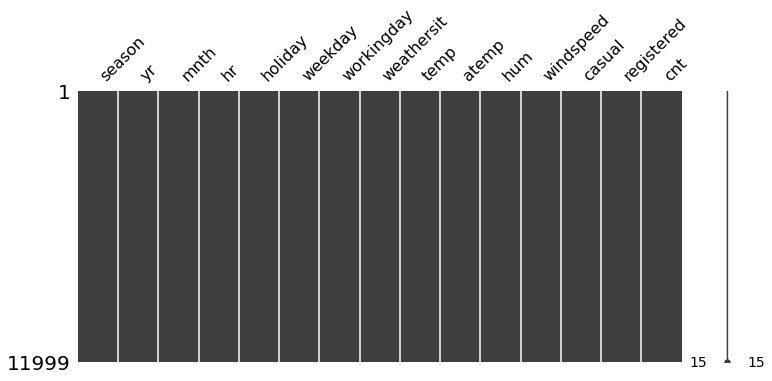

In [517]:
msno.matrix(dailyData,figsize=(12,5))

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

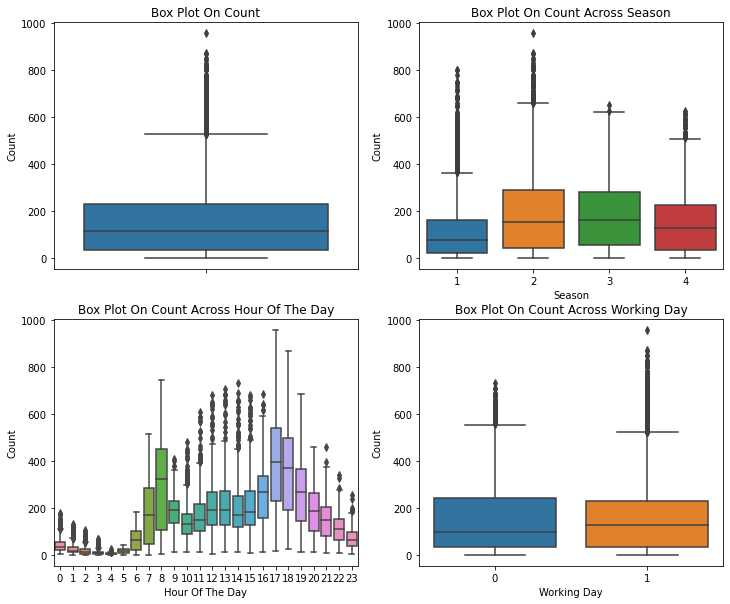

In [519]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=train_df,y="cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=train_df,y="cnt",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train_df,y="cnt",x="hr",orient="v",ax=axes[1][0])
sn.boxplot(data=train_df,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [521]:
train_dfWithoutOutliers = train_df[np.abs(train_df["cnt"]-train_df["cnt"].mean())<=(3*train_df["cnt"].std())]

In [524]:
print ("Shape Of The Before Ouliers: ",train_df.shape)
print ("Shape Of The After Ouliers: ",train_dfWithoutOutliers.shape)

Shape Of The Before Ouliers:  (11999, 16)
Shape Of The After Ouliers:  (11846, 16)


<AxesSubplot:>

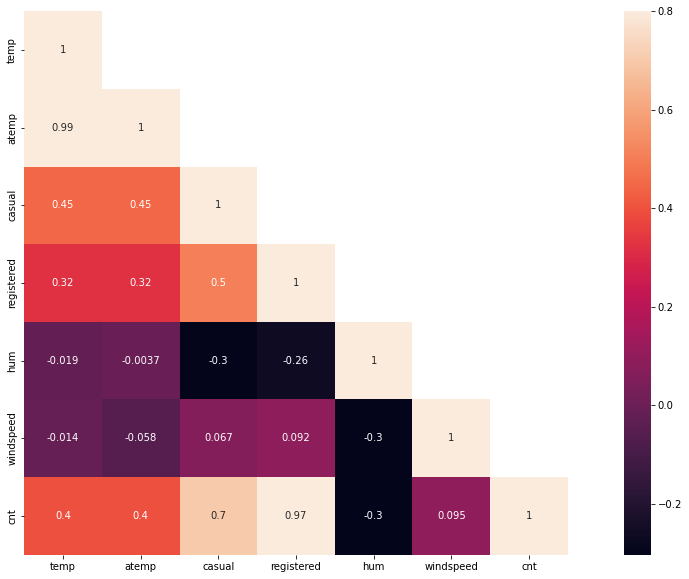

In [527]:
corrMatt = train_df[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='hum', ylabel='cnt'>

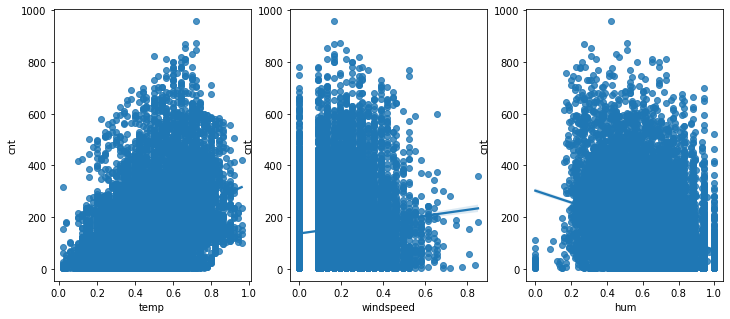

In [532]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=train_df,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=train_df,ax=ax2)
sn.regplot(x="hum", y="cnt", data=train_df,ax=ax3)

[Text(0.5, 0, 'hr Of The Day'),
 Text(0, 0.5, 'Users cnt'),
 Text(0.5, 1.0, 'Average Users cnt By hr Of The Day Across User Type'),
 None]

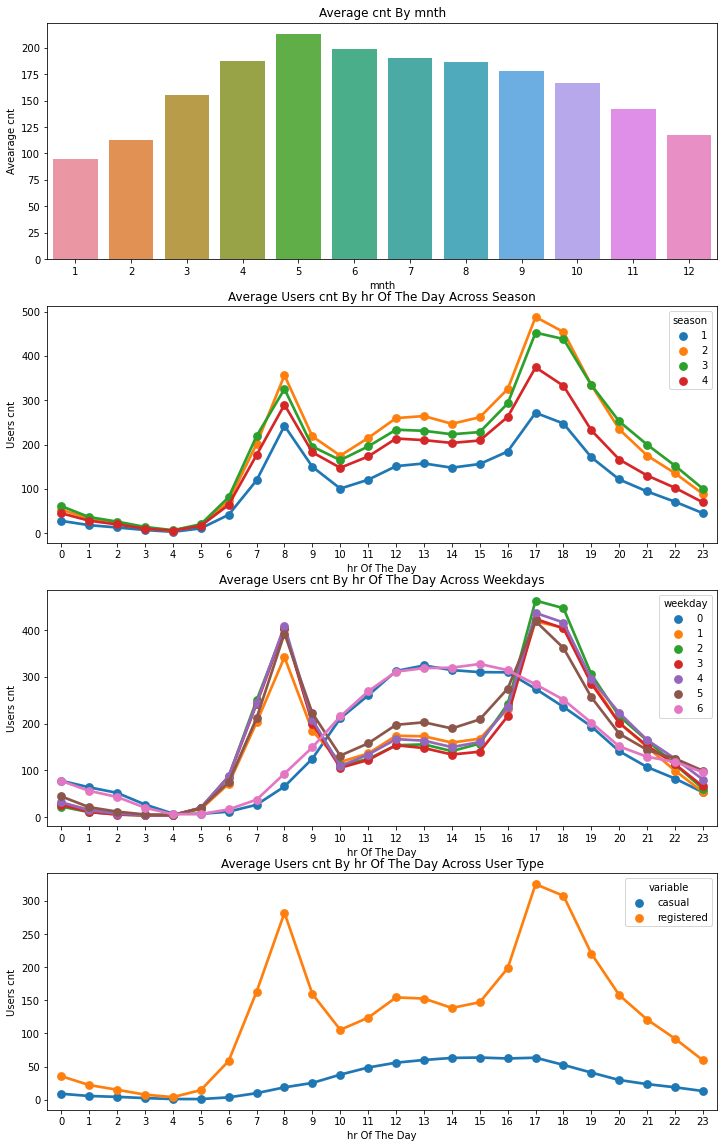

In [535]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)

mnthAggregated = pd.DataFrame(train_df.groupby("mnth")["cnt"].mean()).reset_index()
mnthSorted = mnthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=mnthSorted,x="mnth",y="cnt",ax=ax1)
ax1.set(xlabel='mnth', ylabel='Avearage cnt',title="Average cnt By mnth")

hrAggregated = pd.DataFrame(train_df.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hrAggregated["hr"], y=hrAggregated["cnt"],hue=hrAggregated["season"], data=hrAggregated, join=True,ax=ax2)
ax2.set(xlabel='hr Of The Day', ylabel='Users cnt',title="Average Users cnt By hr Of The Day Across Season",label='big')

hrAggregated = pd.DataFrame(train_df.groupby(["hr","weekday"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hrAggregated["hr"], y=hrAggregated["cnt"],hue=hrAggregated["weekday"], data=hrAggregated, join=True,ax=ax3)
ax3.set(xlabel='hr Of The Day', ylabel='Users cnt',title="Average Users cnt By hr Of The Day Across Weekdays",label='big')

hrTransformed = pd.melt(train_df[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hrAggregated = pd.DataFrame(hrTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hrAggregated["hr"], y=hrAggregated["value"],hue=hrAggregated["variable"],hue_order=["casual","registered"], data=hrAggregated, join=True,ax=ax4)
ax4.set(xlabel='hr Of The Day', ylabel='Users cnt',title="Average Users cnt By hr Of The Day Across User Type",label='big')

In [538]:
categoricalFeatureNames = ["season","holiday","workingday","weathersit","weekday","mnth","yr","hr"]
numericalFeatureNames = ["temp","hum","windspeed","atemp"]
dropFeatures = ['casual',"cnt","dtetime","registered"]

In [546]:
data = train_df.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_34604\685803127.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train_df.append(dataTest)


In [547]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [541]:
dataTrain  = train_df
dataTest  = test_df

In [549]:
dataTrain = data[pd.notnull(data['cnt'])]
dataTest = data[~pd.notnull(data['cnt'])]
yLabels = dataTrain["cnt"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [623]:
#from sklearn.ensemble import RandomForestRegressor
#rfModel = RandomForestRegressor(n_estimators=25)
#yLabelsLog = np.log1p(yLabels)
#print(yLabelsLog.shape)
#print(dataTrain.shape)
#rfModel.fit(dataTrain,yLabelsLog)
#preds = rfModel.predict(X= dataTrain)
#print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

In [ ]:
print(train_df.head(5))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

In [ ]:
En el código de abajo se prueba el dataset bike para hacer el testing.

In [608]:
test_df = pd.read_csv('bike_test.csv')
test_df.head(5)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,20/05/2012,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,20/05/2012,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,20/05/2012,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,20/05/2012,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,20/05/2012,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


In [ ]:
test_df.head(5)
test_df.isna().sum()

In [ ]:
print(test_df.head(5))

In [607]:

#test_df = test_df.drop('yr',axis=1)
#test_df = test_df.drop('mnth',axis=1)
#test_df = test_df.drop('hr',axis=1)
#test_df = test_df.drop('weekday',axis=1)

#test_df = test_df.drop('data_set',axis=1)
#test_df = test_df.drop('instant',axis=1)

In [ ]:
print(test_df.head(5))

In [ ]:
byday = train_df.groupby('weekday')
byday['casual'].sum().reset_index()

In [ ]:
byday['registered'].sum().reset_index()


In [ ]:
 create binary features which show if day is Saturday/Sunday
train_df['Saturday']=0
train_df.Saturday[train_df.weekday==5]=1

train_df['Sunday']=0
train_df.Sunday[train_df.weekday==6]=1
print(train_df.head(5))

In [ ]:
dataRel = train_df.drop(['dteday', 'cnt'], axis=1)


In [ ]:
#print(train_df.head(4))
print(train_df['temp'])

In [ ]:
#en este codigo se busca encontrar tb. los Nan

test_df.isna().sum()

In [ ]:
all_df.tail(5)

En este código se busca concatenar ambos datasets para lluego separar por horas

In [ ]:
Luego de haber concatenado todo, buscamos mostrar en el histograma
la distribución de los datos.
Esto nos permite de forma analítica conocer el contenido.
Si realmente afecta el clima, el horario laboral o la humedad, etc.

In [ ]:

fig, ax = plt.subplots()
ax.hist(all_df['temp'],edgecolor='yellow', label="Rowing",bins=10)
ax.set_xlabel("Temperatura")
ax.set_ylabel("valores")
plt.title('Distribucición de la temperatura')

fig, ax = plt.subplots(1)
ax.hist(all_df['atemp'], label="Rowing",bins=10,color='black',edgecolor='green')
ax.set_xlabel("grados Celsius")
ax.set_ylabel("valores")
plt.title('Sensación térmica en grados Celsius')


fig, ax = plt.subplots()
ax.hist(all_df['hum'], label="Rowing",bins=10,color='orange',edgecolor='green')
ax.set_xlabel("Humedad")
ax.set_ylabel("valores")
plt.title('Distribucición de la Humedad')

fig, ax = plt.subplots()
ax.hist(all_df['windspeed'], label="Rowing",bins=10,color='green',edgecolor='pink')
ax.set_xlabel("Velocidad del viento")
ax.set_ylabel("valores")
plt.title('Distribucición de la velocidad del viento')

fig, ax = plt.subplots()
ax.hist(all_df['workingday'], label="Rowing",bins=10,color='pink',edgecolor='green')
ax.set_xlabel("Días laborables")
ax.set_ylabel("valores")
plt.title('Distribucición de días laborables')
plt.tight_layout();

fig, ax = plt.subplots()
ax.hist(all_df['holiday'], label="Rowing",bins=10,color='grey',edgecolor='green')
ax.set_xlabel("Días feriados")
ax.set_ylabel("valores")
plt.title('Distribucición de días feriados')
plt.tight_layout();

fig, ax = plt.subplots()
ax.hist(all_df['season'], label="Rowing",bins=10,color='purple',edgecolor='green')
ax.set_xlabel("Estación")
ax.set_ylabel("valores")
plt.title('Estaciones en el estado de Washignton')
plt.tight_layout();

fig, ax = plt.subplots()
ax.hist(all_df['weathersit'], label="Rowing",bins=10,color='magenta',edgecolor='green')
ax.set_xlabel("Clima")
ax.set_ylabel("valores")
plt.title('Clima en Washignton D.C.')
plt.tight_layout();

La primera prueba que se ha realizado, ha sido la siguiente:
    Utilizar solamente algunas columnas basandonos en el histograma.
    Los cuales nos pueden ayudar a predecir.

In [ ]:
print(train_df['temp'])

In [578]:
rf = RandomForestRegressor(n_estimators=25,
                           random_state=2)
                           
# Fit rf to the training set
X_train=train_df
y_train= train_df[['temp']]


Luego, una vez que se construye 
el modelo Random Forest, podemos extraer
directamente la importancia de las características 
con random forest, utilizando el atributo 
feature_importances_ del modelo
RandomForestClassifier
En la gráfica retorna los valores que considera más importante al 
tomar la temperatura.

In [611]:
rf = RandomForestRegressor(n_estimators=100,
                           random_state=2)
                           
# Fit rf to the training set
X_train=train_df[['windspeed','hum','workingday','weathersit','hr']]
print(X_train)
y_train= train_df['temp']
#print(y_train)
#print(X_train)
grid_rf=(rf.fit(X_train, y_train))
print(grid_rf)

       windspeed   hum workingday weathersit  hr
0         0.0000  0.81          0          1   0
1         0.0000  0.80          0          1   1
2         0.0000  0.80          0          1   2
3         0.0000  0.75          0          1   3
4         0.0000  0.75          0          1   4
...          ...   ...        ...        ...  ..
11994     0.1642  0.56          0          1  23
11995     0.1045  0.53          0          1   0
11996     0.0000  0.52          0          1   1
11997     0.0000  0.52          0          1   2
11998     0.0896  0.56          0          1   3

[11999 rows x 5 columns]
RandomForestRegressor(random_state=2)


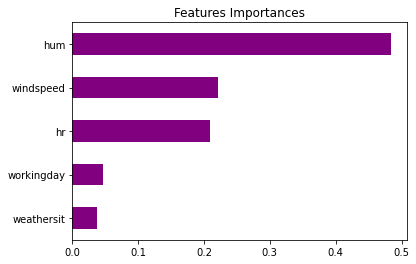

In [612]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='purple')
plt.title('Features Importances')
plt.show()



In [ ]:
Para el test, utilizamos las mismas columnas.

In [621]:
X_train=train_df[['hum','workingday','weathersit','hr','temp']]
print(X_train)
X_test=test_df[['hum','workingday','weathersit','hr','temp']]

y_train= train_df['windspeed']
y_test= test_df['windspeed']

        hum workingday weathersit  hr  temp
0      0.81          0          1   0  0.24
1      0.80          0          1   1  0.22
2      0.80          0          1   2  0.22
3      0.75          0          1   3  0.24
4      0.75          0          1   4  0.24
...     ...        ...        ...  ..   ...
11994  0.56          0          1  23  0.60
11995  0.53          0          1   0  0.58
11996  0.52          0          1   1  0.56
11997  0.52          0          1   2  0.56
11998  0.56          0          1   3  0.54

[11999 rows x 5 columns]


In [622]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = sqrt(mean_squared_error(y_test, y_pred))

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 0.18


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- temp
Feature names seen at fit time, yet now missing:
- windspeed

  warnings.warn(message, FutureWarning)
